Here I tried to fine-tune a classification reberta model on the sarc_emojis_1000 dataset. The classification is for the 20 most common emojies in sarcastic comments. I'm not sure if this is correct.

In [ ]:
! gdown 1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx #sarc_emojis_1000.csv
! pip install transformers

Downloading...
From: https://drive.google.com/uc?id=1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx
To: /content/sarc_emojis_1000.csv
100% 1.60M/1.60M [00:00<00:00, 62.1MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.4 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 596 kB 46.4 MB/s 
     |████████████████████████████████| 6.6 MB 31.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.33.117.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.117.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Batch size: 256


In [ ]:
import pandas as pd
df = pd.read_csv('sarc_emojis_1000.csv')
df.head()

,label,text
0,😒,so.....actually wanting to help people face di...
1,😒,and you know they are going to stick around &a...
2,😒,yea. this is what you’ll should be reporting.
3,😒,kids are cute and all until they ask you your ...
4,😒,i love it when i text someone and they don’t r...


In [ ]:
emojies = ['😒','😂','👍','👌','🙄','😑','😊','😉','😏','😁','😔','😡','😐','😳','😜','😄','👏','☺','🤔','😃']
num_categories = 20

# first extract label column and convert to number
labels = [emojies.index(emoji) for emoji in df['label'].values]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), labels)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*len(labels))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=20)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')],
        )
 
history=model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

model.save_weights('./saved_weights.h5')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
70/70 [==============================] - 105s 289ms/step - loss: 3.0475 - sparse_categorical_accuracy: 0.0134 - Sparse_Top_3_Categorical_Accuracy: 0.0646 - val_loss: 3.1156 - val_sparse_categorical_accuracy: 0.0000e+00 - val_Sparse_Top_3_Categorical_Accuracy: 0.0000e+00
Epoch 2/6
70/70 [==============================] - 13s 192ms/step - loss: 3.0152 - sparse_categorical_accuracy: 0.0260 - Sparse_Top_3_Categorical_Accuracy: 0.1064 - val_loss: 3.2265 - val_sparse_categorical_accuracy: 0.0000e+00 - val_Sparse_Top_3_Categorical_Accuracy: 0.0000e+00
Epoch 3/6
70/70 [==============================] - 13s 186ms/step - loss: 3.0039 - sparse_categorical_accuracy: 0.0249 - Sparse_Top_3_Categorical_Accuracy: 0.0963 - val_loss: 3.3365 - val_sparse_categorical_accuracy: 0.0000e+00 - val_Sparse_Top_3_Categorical_Accuracy: 0.0000e+00
Epoch 4/6
70/70 [==============================] - 13s 187ms/step - loss: 2.9561 - sparse_categorical_accuracy: 0.0299 - Sparse_Top_3_Categorical_Accuracy: 0.1

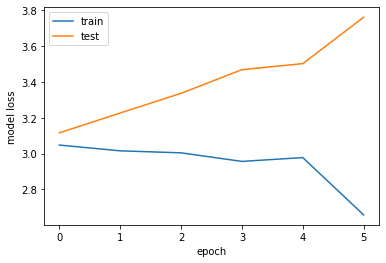

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()